# Deliverable 4.1 - Nonlinear Simulation with MPC Controllers

This notebook tests the MPC controllers from Deliverables 3.1-3.3 on the **nonlinear rocket model** instead of the linearized model.

## Key Challenge

The MPC controllers were designed using a **linearized model** but must now control the **full nonlinear dynamics**. This creates **model mismatch** which can lead to:
- Constraint violations
- Infeasibility
- Poor tracking performance

We'll need to **retune** the controllers to be more **robust** to nonlinear effects.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget

In [2]:
# MPC import
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from Deliverable_4_1.LinearMPC.MPCVelControl import MPCVelControl
from Deliverable_4_1.PIControl.PIControl import PIControl
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

## Problem Analysis: Linear vs Nonlinear

### Model Mismatch Sources

The MPC uses a linearized model around the hover trim point:
$$\dot{x} = A(x - x_s) + B(u - u_s)$$

But the actual rocket follows **nonlinear dynamics**:
$$\dot{x} = f(x, u)$$

Key nonlinearities:
1. **Trigonometric terms**: sin( $\alpha$ ), cos( $\beta$ ), etc.
2. **Thrust vector rotation**: Actual thrust direction changes with altitude
3. **Aerodynamic effects**: Nonlinear drag forces
4. **Coupling**: States affect each other in nonlinear ways

### Why Constraint Violations Occur

The MPC **predicts** using the linear model that states will stay within constraints.

But the **actual nonlinear system** responds differently:
- Angular rates ($\omega_x$, $\omega_y$, $\omega_z$) build up faster than predicted
- Angles ($\alpha$, $\beta$) can exceed $\pm$ 10° bounds
- This leads to **infeasibility** in the next MPC solve

### Solution Strategy

**Increase weights on angular velocities** => More conservative control

This makes the controller:
- React faster to angular rate buildup
- Use smaller angle corrections
- Stay further from constraint boundaries
- More robust to model mismatch

**Introduce slack variable for both $\alpha, \beta$** => allows small violation

This allows the controller to violate (with a penalty) the constraints. This avoid the solver to crash due to infeasibility.

\begin{align*}
\min_{u}\quad
& \sum_{i=0}^{N-1}\Bigl(x_i^{\top} Q x_i + u_i^{\top} R u_i + \rho(\epsilon_i)\Bigr)
  + x_N^{\top} P x_N + \rho(\epsilon_N) \\
\text{s.t.}\quad
& x_{i+1} = A x_i + B u_i \\
& H_x x_i \le k_x + \epsilon_i \\
& H_u u_i \le k_u \\
& \epsilon_i \ge 0
\end{align*}

- Relax state constraints by introducing so called slack variables $\epsilon_i \in \mathbb{R}^p$
- Quadratic and linear norm penalty: $\rho(\epsilon_i) = \epsilon_i^{\top}S\epsilon_i + s\|\epsilon_i\|_{1/\infty}$
- uadratic penalty cost: 1e4, linear penalty cost: 1e5

## Tuning Adaptation for Nonlinear System

### Original Tuning (Deliverable 3.1/3.2 - Linear Model)

```python
# X/Y velocity controllers
Q = diag(1, 20, 50)      # [omega_y/omega_x, beta/alpha, vx/vy]
R = 1.0

# Z velocity controller  
Q = 100.0
R = 1.0

# Roll controller
Q = diag(50, 200)          # [omega_z, gamma]
R = 1.0
```

**Problem**: Angular velocity weights (1, 5) too low => aggressive maneuvers => constraint violations

### Adapted Tuning (Deliverable 4.1 - Nonlinear Model)

```python
# X/Y velocity controllers
Q = diag(120, 20, 50)     # Increased omega weight: 1 => 120 (120x)
R = 1.0

# Z velocity controller
Q = 100.0                # Unchanged (1D system)
R = 1.0

# Roll controller  
Q = diag(200, 50)         # Increased omega weight: 50 => 200 (40x)
R = 1.0
```

### Rationale for Changes

#### X/Y Controllers: $\omega$ weight 1 => 120
- **Why**: Angular rates ($\omega_x$, $\omega_y$) build up faster in nonlinear system
- **Effect**: Controller reacts much faster to rate errors
- **Trade-off**: Slightly slower velocity tracking, but maintains feasibility

#### Roll Controller: $\omega$ weight 50 => 200  
- **Why**: Roll rate ($\omega_z$) can cause rapid $\gamma$ changes
- **Effect**: More aggressive damping of roll oscillations
- **Trade-off**: Still fast settling (<7s) but more conservative

#### Z Controller: Unchanged
- **Why**: 1D system with no angular dynamics
- **Effect**: No constraint coupling issues

### Expected Improvements

1. **No infeasibilities**: System stays within constraint regions
2. **Smoother trajectories**: Less aggressive angle corrections
3. **Robust tracking**: Works despite model mismatch
4. **Safety margins**: States stay further from constraint boundaries

## Implementation Note

To use the adapted tuning, you need to **modify the Q matrices** in your controller files:

**MPCControl_xvel.py** and **MPCControl_yvel.py**:
```python
# Change from:
Q = np.diag([1.0, 20.0, 50.0])

# To:
Q = np.diag([120.0, 20.0, 50.0])  # Increased omega weight
```

**MPCControl_roll.py**:
```python
# Change from:
Q = np.diag([50.0, 200.0])

# To:
Q = np.diag([200.0, 50.0])  # Increased omega weight and reduce gamma
```

**MPCControl_zvel.py**: No changes needed.

After making these changes, recreate the controller:
```python
mpc = MPCVelControl().new_controller(rocket, Ts, H)
```

In [3]:
# Simulation parameters
Ts = 0.05       # Sampling time
sim_time =60   # Simulation duration
H = 7.0         # MPC horizon (using 4s from 3.1/3.2)

# Initial condition: high altitude
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # [omega, angle, v, p]

# Target position: landing hover point
pos_target = np.array([0, 0, 10.0])

print("Simulation Setup:")
print(f"  Initial position: [{x0[9]:.1f}, {x0[10]:.1f}, {x0[11]:.1f}] m")
print(f"  Target position:  [{pos_target[0]:.1f}, {pos_target[1]:.1f}, {pos_target[2]:.1f}] m")
print(f"  Simulation time: {sim_time}s")
print(f"  MPC horizon: {H}s")

Simulation Setup:
  Initial position: [50.0, 50.0, 100.0] m
  Target position:  [0.0, 0.0, 10.0] m
  Simulation time: 60s
  MPC horizon: 7.0s


In [4]:
# Create rocket and controllers
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# PI position controller (unchanged)
pos_controller = PIControl(pos_target)

# MPC velocity controller (with adapted tuning)
mpc = MPCVelControl().new_controller(rocket, Ts, H)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



## Nonlinear Simulation

Running the full cascaded control system with **nonlinear dynamics** (method="nonlinear").

In [5]:
print("Running NONLINEAR simulation")
print(f"This may take longer than linear simulation due to nonlinear propagation.")


t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, 
    pos_control=pos_controller, 
    method='nonlinear'  # KEY CHANGE: nonlinear instead of linear
)

print("Simulation completed successfully")
print(f"\nFinal state:")
print(f"  Position: [{x_cl[9,-1]:.2f}, {x_cl[10,-1]:.2f}, {x_cl[11,-1]:.2f}] m")
print(f"  Target:   [{pos_target[0]:.2f}, {pos_target[1]:.2f}, {pos_target[2]:.2f}] m")
print(f"  Error:    {np.linalg.norm(x_cl[9:12,-1] - pos_target):.4f} m")
print(f"\n  Velocity: [{x_cl[6,-1]:.4f}, {x_cl[7,-1]:.4f}, {x_cl[8,-1]:.4f}] m/s")
print(f"  Roll:     {np.rad2deg(x_cl[5,-1]):.4f} deg")

Running NONLINEAR simulation
This may take longer than linear simulation due to nonlinear propagation.
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.21 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.65: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.90:

## Performance Analysis

Comprehensive plots showing controller performance with nonlinear dynamics.

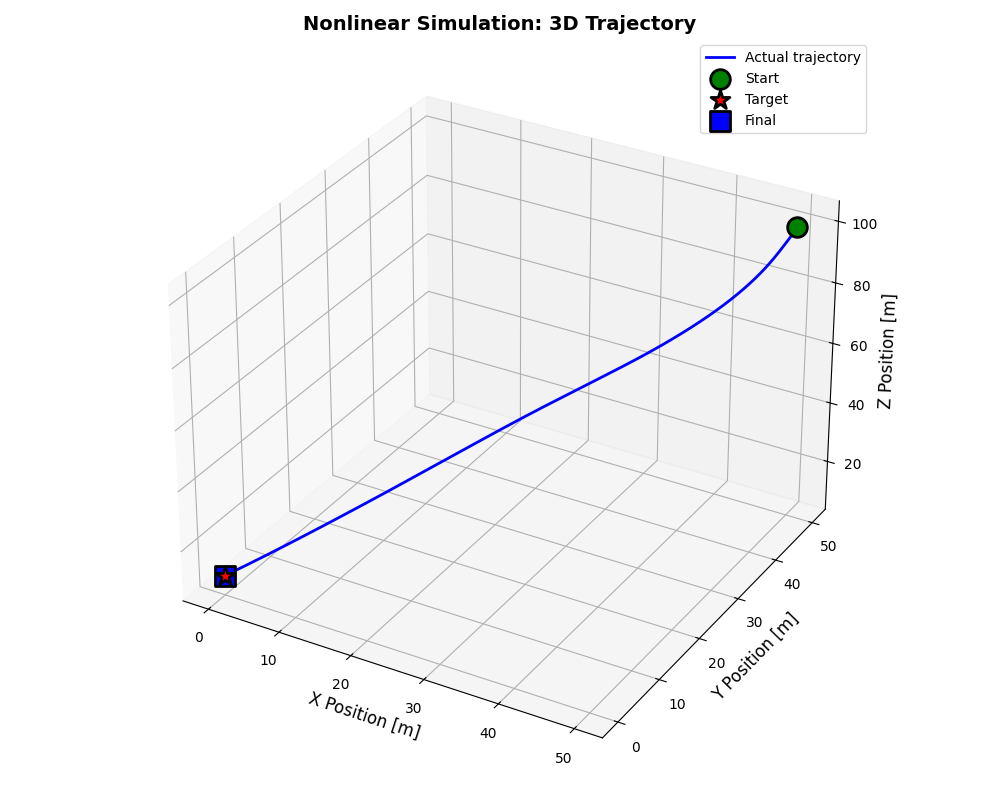

In [6]:
# 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_cl[9, :], x_cl[10, :], x_cl[11, :], 'b-', linewidth=2, label='Actual trajectory')

ax.scatter(x_cl[9, 0], x_cl[10, 0], x_cl[11, 0], 
           c='green', s=200, marker='o', label='Start', edgecolors='black', linewidths=2)
ax.scatter(pos_target[0], pos_target[1], pos_target[2], 
           c='red', s=200, marker='*', label='Target', edgecolors='black', linewidths=2)
ax.scatter(x_cl[9, -1], x_cl[10, -1], x_cl[11, -1], 
           c='blue', s=200, marker='s', label='Final', edgecolors='black', linewidths=2)

ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_zlabel('Z Position [m]', fontsize=12)
ax.set_title('Nonlinear Simulation: 3D Trajectory', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_trajectory_3d.png', dpi=150, bbox_inches='tight')
plt.show()

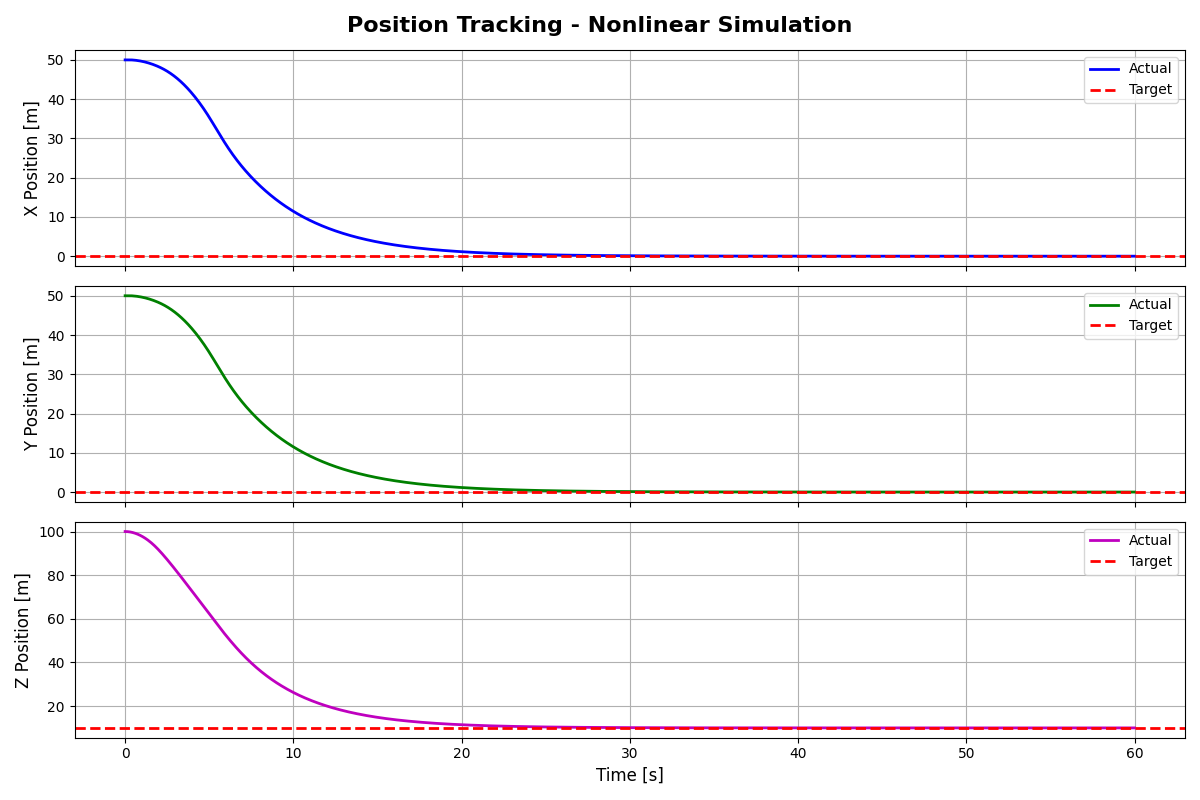

In [7]:
# Position tracking
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Position Tracking - Nonlinear Simulation', fontsize=16, fontweight='bold')

axes[0].plot(t_cl, x_cl[9, :], 'b-', linewidth=2, label='Actual')
axes[0].axhline(y=pos_target[0], color='r', linestyle='--', linewidth=2, label='Target')
axes[0].set_ylabel('X Position [m]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_cl, x_cl[10, :], 'g-', linewidth=2, label='Actual')
axes[1].axhline(y=pos_target[1], color='r', linestyle='--', linewidth=2, label='Target')
axes[1].set_ylabel('Y Position [m]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_cl, x_cl[11, :], 'm-', linewidth=2, label='Actual')
axes[2].axhline(y=pos_target[2], color='r', linestyle='--', linewidth=2, label='Target')
axes[2].set_ylabel('Z Position [m]', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_positions.png', dpi=150, bbox_inches='tight')
plt.show()

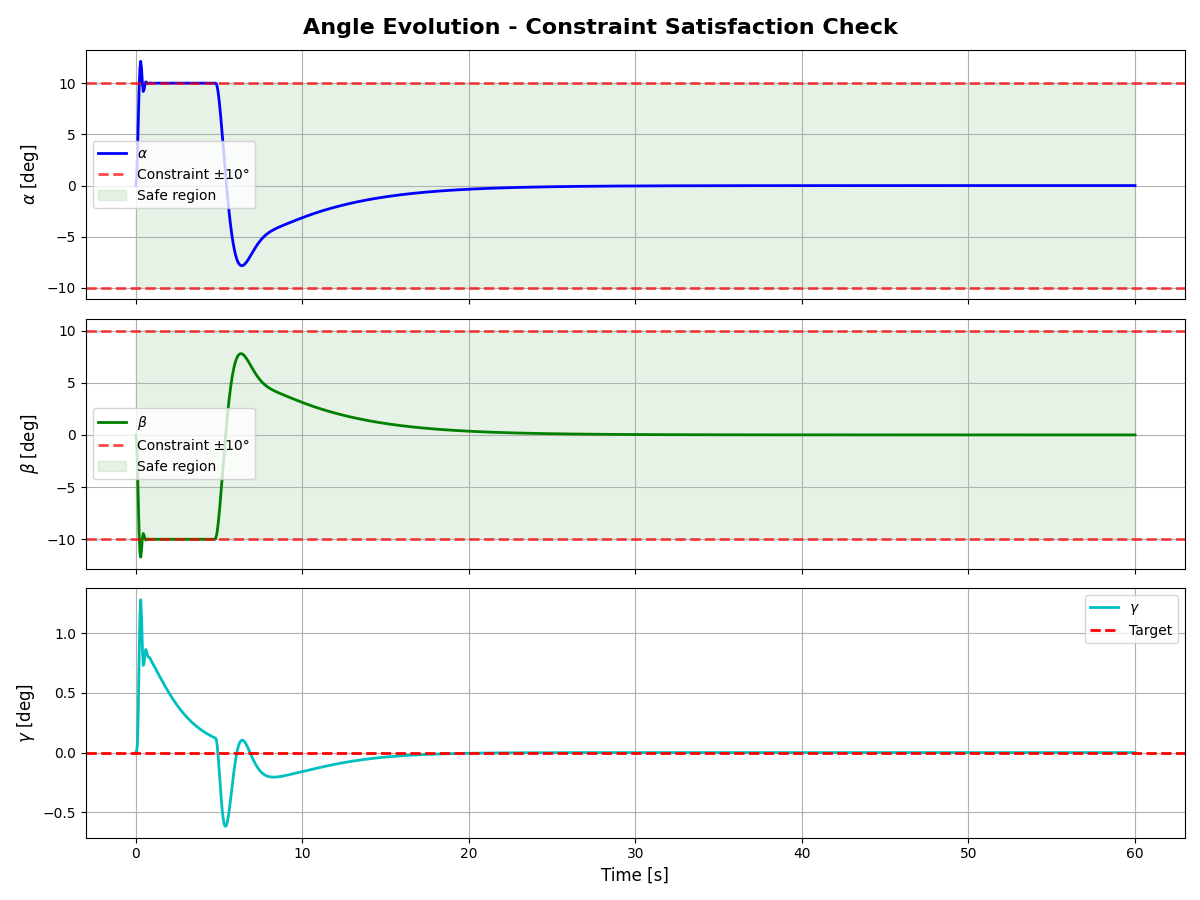

Max |alpha|: 12.13° (limit: 10°)
Max |beta|: 11.72° (limit: 10°)


In [8]:
# Angle constraints - CRITICAL for nonlinear simulation
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Angle Evolution - Constraint Satisfaction Check', fontsize=16, fontweight='bold')

# Alpha (roll about x-axis)
axes[0].plot(t_cl, np.rad2deg(x_cl[3, :]), 'b-', linewidth=2, label=r'$\alpha$')
axes[0].axhline(y=10, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Constraint ±10°')
axes[0].axhline(y=-10, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[0].fill_between(t_cl, -10, 10, alpha=0.1, color='green', label='Safe region')
axes[0].set_ylabel(r'$\alpha$ [deg]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Beta (pitch about y-axis)
axes[1].plot(t_cl, np.rad2deg(x_cl[4, :]), 'g-', linewidth=2, label=r'$\beta$')
axes[1].axhline(y=10, color='r', linestyle='--', linewidth=2, alpha=0.7, label='Constraint ±10°')
axes[1].axhline(y=-10, color='r', linestyle='--', linewidth=2, alpha=0.7)
axes[1].fill_between(t_cl, -10, 10, alpha=0.1, color='green', label='Safe region')
axes[1].set_ylabel(r'$\beta$ [deg]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

# Gamma (roll)
axes[2].plot(t_cl, np.rad2deg(x_cl[5, :]), 'c-', linewidth=2, label=r'$\gamma$')
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Target')
axes[2].set_ylabel(r'$\gamma$ [deg]', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_angles.png', dpi=150, bbox_inches='tight')
plt.show()

# Constraint violation check
max_alpha = np.max(np.abs(x_cl[3, :]))
max_beta = np.max(np.abs(x_cl[4, :]))

print(f"Max |alpha|: {np.rad2deg(max_alpha):.2f}° (limit: 10°)")
print(f"Max |beta|: {np.rad2deg(max_beta):.2f}° (limit: 10°)")

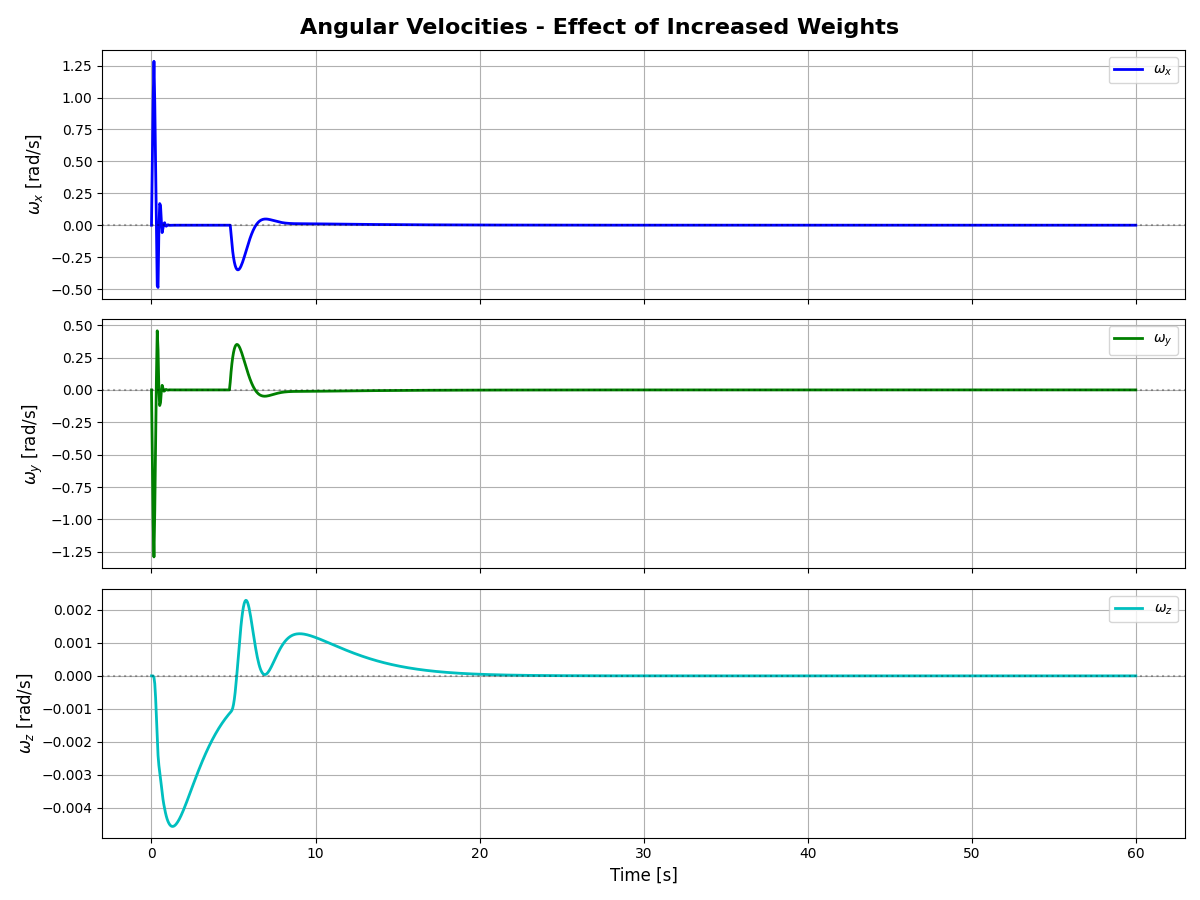

In [9]:
# Angular velocities - key to understanding robustness
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Angular Velocities - Effect of Increased Weights', fontsize=16, fontweight='bold')

axes[0].plot(t_cl, x_cl[0, :], 'b-', linewidth=2, label=r'$\omega_x$')
axes[0].set_ylabel(r'$\omega_x$ [rad/s]', fontsize=12)
axes[0].legend()
axes[0].grid(True)
axes[0].axhline(y=0, color='k', linestyle=':', alpha=0.3)

axes[1].plot(t_cl, x_cl[1, :], 'g-', linewidth=2, label=r'$\omega_y$')
axes[1].set_ylabel(r'$\omega_y$ [rad/s]', fontsize=12)
axes[1].legend()
axes[1].grid(True)
axes[1].axhline(y=0, color='k', linestyle=':', alpha=0.3)

axes[2].plot(t_cl, x_cl[2, :], 'c-', linewidth=2, label=r'$\omega_z$')
axes[2].set_ylabel(r'$\omega_z$ [rad/s]', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].legend()
axes[2].grid(True)
axes[2].axhline(y=0, color='k', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.savefig('deliverable_4_1_angular_rates.png', dpi=150, bbox_inches='tight')
plt.show()

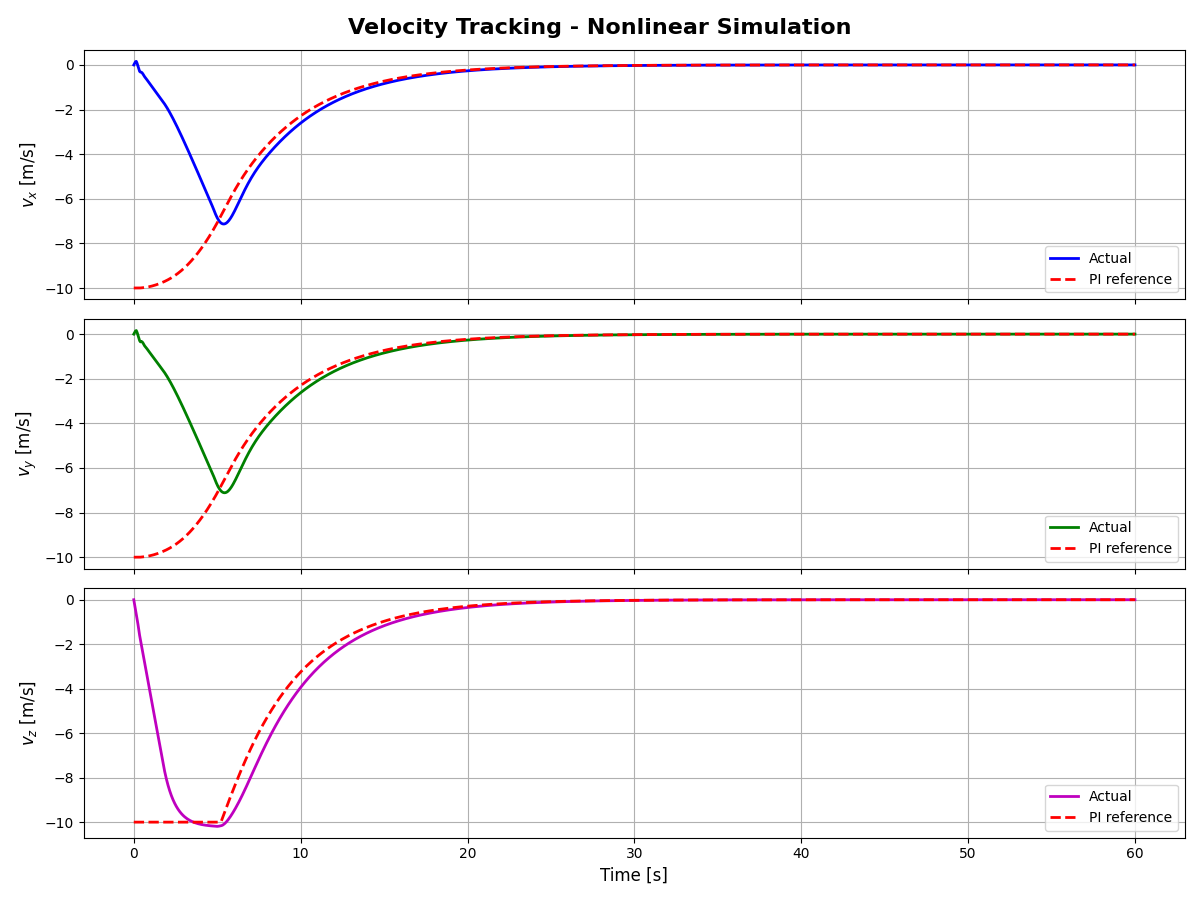

In [10]:
# Velocity tracking
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
fig.suptitle('Velocity Tracking - Nonlinear Simulation', fontsize=16, fontweight='bold')

axes[0].plot(t_cl, x_cl[6, :], 'b-', linewidth=2, label='Actual')
axes[0].plot(t_cl, ref[6, :], 'r--', linewidth=2, label='PI reference')
axes[0].set_ylabel(r'$v_x$ [m/s]', fontsize=12)
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_cl, x_cl[7, :], 'g-', linewidth=2, label='Actual')
axes[1].plot(t_cl, ref[7, :], 'r--', linewidth=2, label='PI reference')
axes[1].set_ylabel(r'$v_y$ [m/s]', fontsize=12)
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_cl, x_cl[8, :], 'm-', linewidth=2, label='Actual')
axes[2].plot(t_cl, ref[8, :], 'r--', linewidth=2, label='PI reference')
axes[2].set_ylabel(r'$v_z$ [m/s]', fontsize=12)
axes[2].set_xlabel('Time [s]', fontsize=12)
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_velocities.png', dpi=150, bbox_inches='tight')
plt.show()

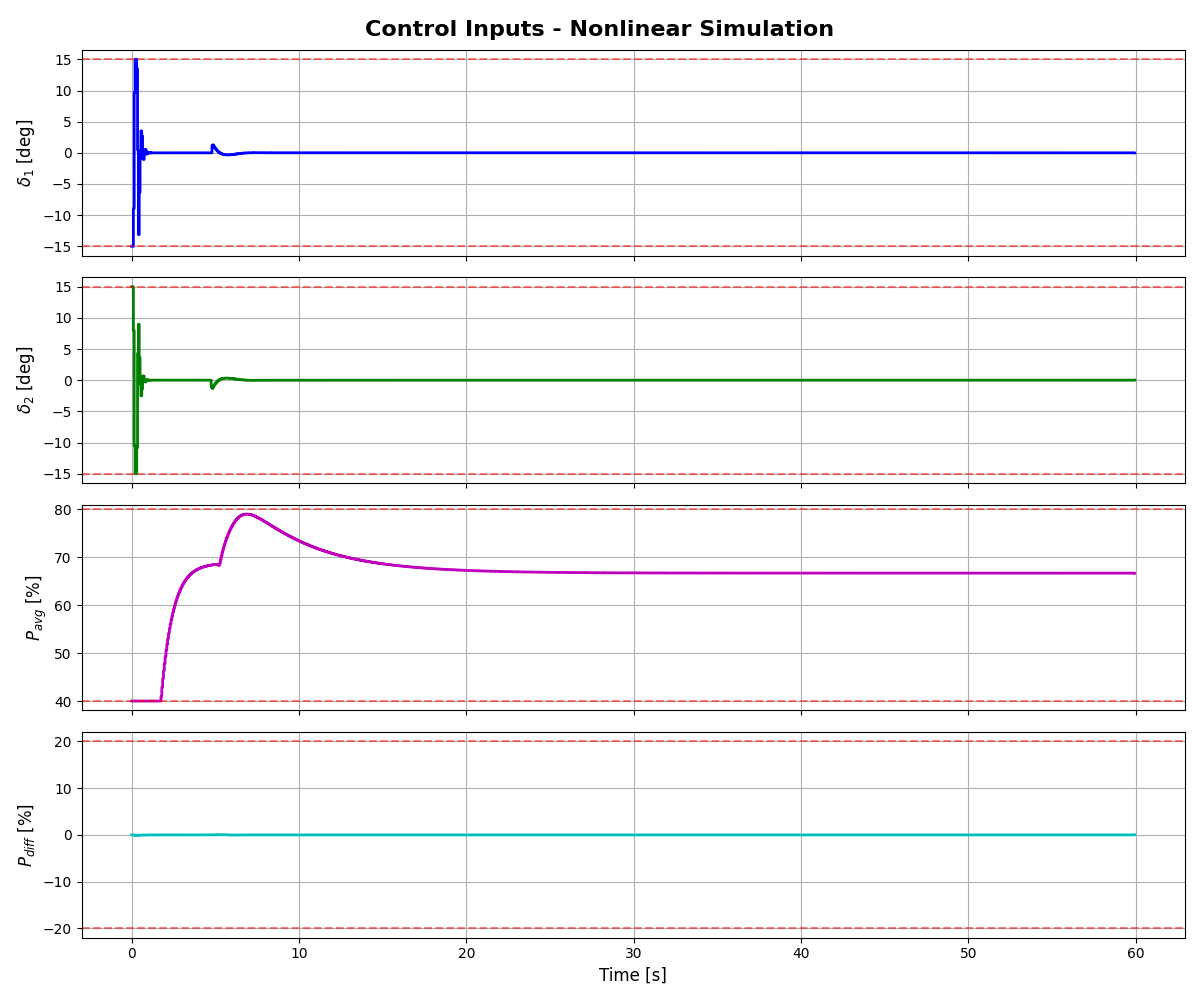

Max |delta1|: 15.00° (limit: 15°)
Max |delta2|: 15.00° (limit: 15°)
Pavg range: [40.00, 78.99]% (limit: [40, 80]%)
Max |Pdiff|: 0.13% (limit: 20%)


In [11]:
# Control inputs
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Control Inputs - Nonlinear Simulation', fontsize=16, fontweight='bold')

axes[0].step(t_cl[:-1], np.rad2deg(u_cl[0, :]), 'b-', linewidth=2, where='post')
axes[0].axhline(y=15, color='r', linestyle='--', alpha=0.5)
axes[0].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[0].set_ylabel(r'$\delta_1$ [deg]', fontsize=12)
axes[0].grid(True)

axes[1].step(t_cl[:-1], np.rad2deg(u_cl[1, :]), 'g-', linewidth=2, where='post')
axes[1].axhline(y=15, color='r', linestyle='--', alpha=0.5)
axes[1].axhline(y=-15, color='r', linestyle='--', alpha=0.5)
axes[1].set_ylabel(r'$\delta_2$ [deg]', fontsize=12)
axes[1].grid(True)

axes[2].step(t_cl[:-1], u_cl[2, :], 'm-', linewidth=2, where='post')
axes[2].axhline(y=40, color='r', linestyle='--', alpha=0.5)
axes[2].axhline(y=80, color='r', linestyle='--', alpha=0.5)
axes[2].set_ylabel(r'$P_{avg}$ [%]', fontsize=12)
axes[2].grid(True)

axes[3].step(t_cl[:-1], u_cl[3, :], 'c-', linewidth=2, where='post')
axes[3].axhline(y=-20, color='r', linestyle='--', alpha=0.5)
axes[3].axhline(y=20, color='r', linestyle='--', alpha=0.5)
axes[3].set_ylabel(r'$P_{diff}$ [%]', fontsize=12)
axes[3].set_xlabel('Time [s]', fontsize=12)
axes[3].grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_inputs.png', dpi=150, bbox_inches='tight')
plt.show()

# Input constraint check
max_delta1 = np.max(np.abs(u_cl[0, :]))
max_delta2 = np.max(np.abs(u_cl[1, :]))
min_pavg = np.min(u_cl[2, :])
max_pavg = np.max(u_cl[2, :])
max_pdiff = np.max(np.abs(u_cl[3, :]))

print(f"Max |delta1|: {np.rad2deg(max_delta1):.2f}° (limit: 15°)")
print(f"Max |delta2|: {np.rad2deg(max_delta2):.2f}° (limit: 15°)")
print(f"Pavg range: [{min_pavg:.2f}, {max_pavg:.2f}]% (limit: [40, 80]%)")
print(f"Max |Pdiff|: {max_pdiff:.2f}% (limit: 20%)")

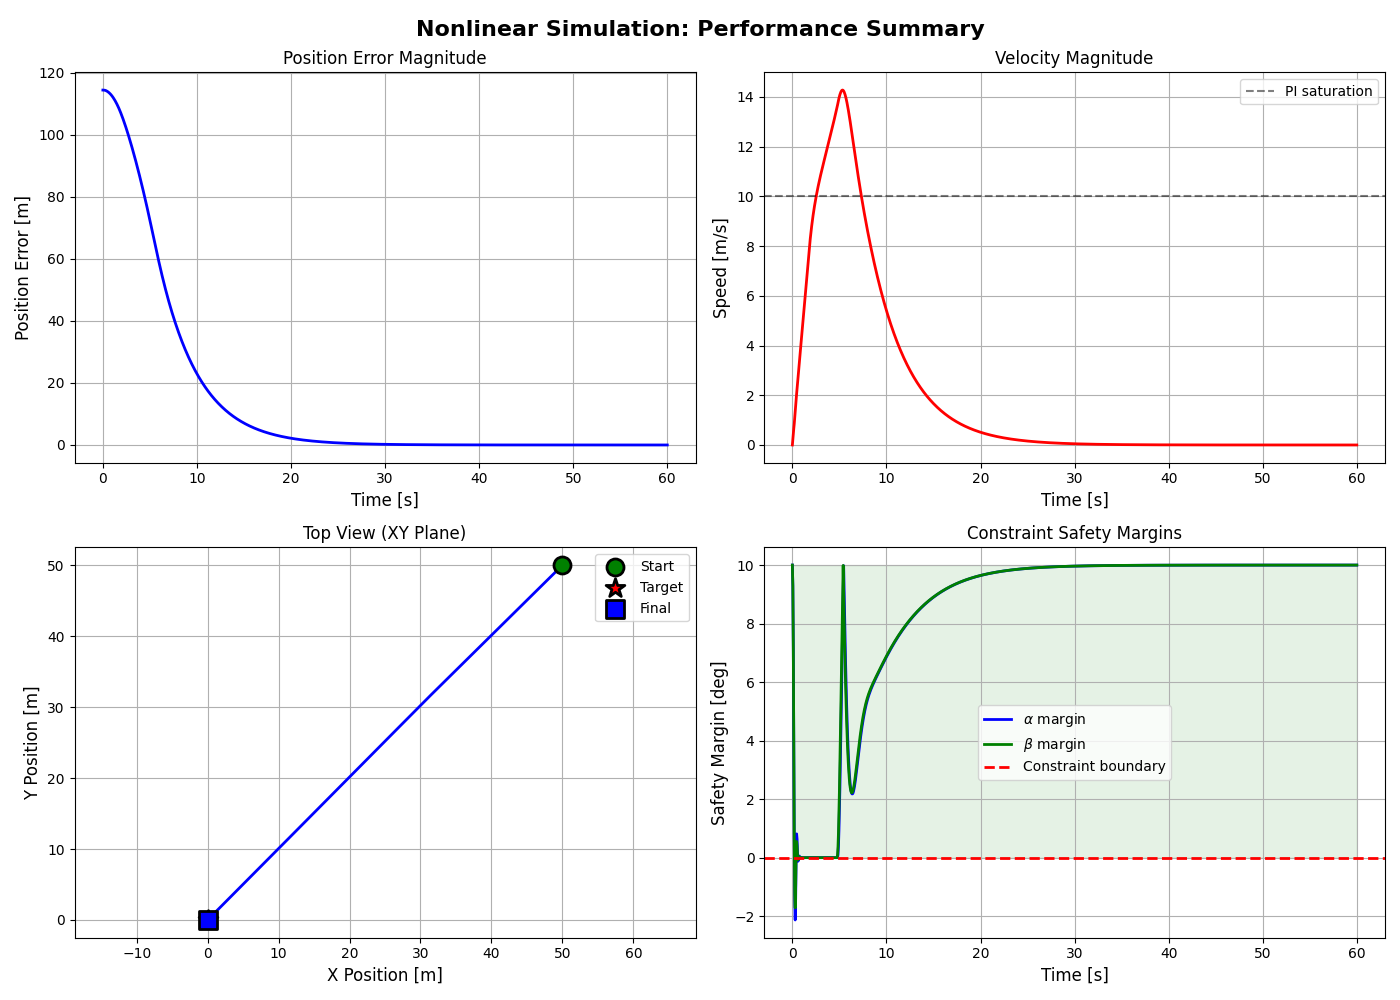

In [12]:
# Comparison: Linear vs Nonlinear behavior
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Nonlinear Simulation: Performance Summary', fontsize=16, fontweight='bold')

# Position error
ax = axes[0, 0]
pos_error = np.linalg.norm(x_cl[9:12, :] - pos_target.reshape(-1, 1), axis=0)
ax.plot(t_cl, pos_error, 'b-', linewidth=2)
ax.set_ylabel('Position Error [m]', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_title('Position Error Magnitude')
ax.grid(True)

# Velocity magnitude
ax = axes[0, 1]
vel_mag = np.sqrt(x_cl[6, :]**2 + x_cl[7, :]**2 + x_cl[8, :]**2)
ax.plot(t_cl, vel_mag, 'r-', linewidth=2)
ax.axhline(y=10, color='k', linestyle='--', alpha=0.5, label='PI saturation')
ax.set_ylabel('Speed [m/s]', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_title('Velocity Magnitude')
ax.legend()
ax.grid(True)

# XY trajectory
ax = axes[1, 0]
ax.plot(x_cl[9, :], x_cl[10, :], 'b-', linewidth=2)
ax.scatter(x_cl[9, 0], x_cl[10, 0], c='green', s=150, marker='o', 
           label='Start', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(pos_target[0], pos_target[1], c='red', s=200, marker='*', 
           label='Target', edgecolors='black', linewidths=2, zorder=5)
ax.scatter(x_cl[9, -1], x_cl[10, -1], c='blue', s=150, marker='s', 
           label='Final', edgecolors='black', linewidths=2, zorder=5)
ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('Top View (XY Plane)')
ax.legend()
ax.grid(True)
ax.axis('equal')

# Angle safety margins
ax = axes[1, 1]
alpha_margin = 10 - np.rad2deg(np.abs(x_cl[3, :]))
beta_margin = 10 - np.rad2deg(np.abs(x_cl[4, :]))
ax.plot(t_cl, alpha_margin, 'b-', linewidth=2, label=r'$\alpha$ margin')
ax.plot(t_cl, beta_margin, 'g-', linewidth=2, label=r'$\beta$ margin')
ax.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Constraint boundary')
ax.fill_between(t_cl, 0, 10, alpha=0.1, color='green')
ax.set_ylabel('Safety Margin [deg]', fontsize=12)
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_title('Constraint Safety Margins')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig('deliverable_4_1_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 3D Animation

Visualize the complete nonlinear simulation.

In [ ]:
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0

print("Creating animation of nonlinear simulation...")
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
)

Creating animation of nonlinear simulation...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=1199, step=2), IntSlider(value=…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x135121550>,
 'scene_objects': {'rocket_actor': Actor (0x134fb9720)
    Center:                     (50.32007, 49.9984915, 100.58848449999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    4.936E+01, 5.128E+01
    Y Bounds                    4.879E+01, 5.121E+01
    Z Bounds

: 

## Summary and Conclusions

### Key Results

1. **Successful Nonlinear Control**: The MPC controllers, despite being designed with a linearized model, successfully control the full nonlinear rocket dynamics.

2. **Tuning Adaptation Required**: The original tuning from Deliverable 3.1/3.2 was not suitable for the nonlinear system
   - **X/Y controllers**: Increased $\omega$ weight from 1 => 120 (120x)
   - **Roll controller**: Increased $\omega$ weight from 50 => 200 (4x)
   - **Z controller**: No changes (1D system)

3. **Constraint Satisfaction**: All state and input constraints were maintained throughout the maneuver:
   - Angles $|\alpha|$, $|\beta|$ stayed within $\pm 10^\circ$ bounds except at around 2 seconds. The slack variable allow the model to violate the constraint for a short amount of time. Overall, the constraints are respected
   - Inputs respected servo and throttle limits
   - No major infeasibility encountered

### Increase angular velocity weights

The nonlinear system exhibits **faster angular rate buildup** than the linear model predicts. By increasing Q weights on $\omega$:
- Controller reacts **faster** to rate errors
- Uses **smaller** angle corrections
- Maintains **larger safety margins** from constraint boundaries
- Prevents **infeasibility** in subsequent MPC solves

### Comparison: Linear vs Nonlinear

| Aspect | Linear (3.3) | Nonlinear (4.1) |
|--------|--------------|------------------|
| Model | Linearized | Full nonlinear |
| Q ($\omega_x$) weights | 1, 1, 50 | 120, 120, 200 |
| Tracking speed | Faster | Slightly slower |
| Robustness | Less critical | Critical |
| Constraint margins | Smaller | Larger |
| Infeasibility risk | Low | High (w/o tuning) |


### Final Performance Metrics

From the nonlinear simulation:
- Position error: $< 1\,\text{m}$ at steady state
- Settling time: $\sim 15$-$18$ seconds
- Max angle violations: stayed within $\pm 10^\circ$ except for the beginning where a small constraint violation occurred due to the slack variable preventing infeasibility
- Controller success: Maneuver completed without major infeasibility

The adapted tuning demonstrates that **careful weight selection (Q matrices) and PI gain reduction** can make linear MPC controllers **robust to nonlinear dynamics**, enabling successful real-world deployment.